In [144]:
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from sodapy import Socrata
from geopandas import gpd
import pysal as ps

In [131]:
client = Socrata("data.cityofchicago.org", 'EjrjYzG6YAkBx7bPBzME8jD4c')
results = client.get("w3hi-cfa4",limit = 500000)

complaints = pd.DataFrame.from_records(results)

In [132]:
split = complaints['beat'].str.split('|').apply(pd.Series, 1).stack()
split.index = split.index.droplevel(-1)
split.name = 'beat'
del complaints['beat']
split = split.apply(lambda x: x.strip())
complaints = complaints.join(split, how ="right")
complaints['complaint_date'] =  pd.to_datetime(complaints['complaint_date'], format='%Y%m%dT%H:%M:%S.%f')
complaints['complaint_year'] = complaints.complaint_date.dt.year

In [138]:
beats_gpd = gpd.read_file('policebeats.shp')
beats_gpd['beat_num'] = pd.to_numeric(beats_gpd['beat_num'])

In [139]:
race = complaints[['beat','race_of_complainant']].dropna()
race_long = pd.get_dummies(race, columns = ['race_of_complainant']) 
race_long.rename(columns={'race_of_complainant_African American / Black':'Black', 
                          'race_of_complainant_American Indian or Alaskan Native':'AmerIndianAlaskan',
                         'race_of_complainant_Asian or Pacific Islander':'Apia',
                          'race_of_complainant_Hispanic':'Hispanic',
                          'race_of_complainant_Unknown':'Unknown',
                          'race_of_complainant_White':'White'
                         }, inplace=True)
race_long =race_long.groupby(['beat']).agg({'Black':[sum],'AmerIndianAlaskan':[sum],
                                'Apia':[sum],'Hispanic':[sum],
                                'Unknown':[sum],'White':[sum]})
race_long.columns = race_long.columns.droplevel(1)
race_long = race_long.reset_index()
race_long['beat'] = pd.to_numeric(race_long['beat'])

In [140]:
type = complaints[['beat','current_category']].dropna()
type_long = pd.get_dummies(type, columns=['current_category'])
type_long = type_long.rename(columns={'current_category_Bias':'bias',
                         'current_category_Civil Suits':'civilsuits',
                         'current_category_Coercion':'coercion',
                         'current_category_Death or Injury In Custody':'deathinjuryincustody',
                         'current_category_Domestic Violence':'domesticviolence',
                         'current_category_Excessive Force':'excessforce',
                         'current_category_Firearm Discharge - Hits':'firearmhit',
                         'current_category_Firearm Discharge - No Hits':'firearmnohit',
                         'current_category_Firearm Discharge at Animal':'firearmanimal',
                         'current_category_Legal Violation':'legalviol',
                         'current_category_Miscellaneous':'misc',
                         'current_category_Motor Vehicle Related Death':'motordeath',
                         'current_category_OC Discharge':'ocdischarge',
                         'current_category_Operational Violation':'operationviolation',
                         'current_category_Search or Seizure':'searchseizure',
                         'current_category_Taser Discharge':'taserdischarge',
                         'current_category_Taser Notification':'tasernotif',
                         'current_category_Unlawful Denial of Counsel':'denialcounsel',
                         'current_category_Unnecessary Display of Weapon':'unnecessarydispweapon',
                         'current_category_Verbal Abuse':'verbalabuse'})
type_long = type_long.groupby(['beat']).agg({'bias':[sum],'civilsuits':[sum],
                                'coercion':[sum],'deathinjuryincustody':[sum],
                                'domesticviolence':[sum],'excessforce':[sum],
                               'firearmhit':[sum],'firearmnohit':[sum],
                                'firearmanimal':[sum],'legalviol':[sum],
                                'misc':[sum],'motordeath':[sum],
                               'ocdischarge':[sum],'operationviolation':[sum],
                                'searchseizure':[sum],'taserdischarge':[sum],
                                'tasernotif':[sum],'denialcounsel':[sum],
                               'unnecessarydispweapon':[sum],'verbalabuse':[sum]})
type_long.columns = type_long.columns.droplevel(1)
type_long = type_long.reset_index()
type_long['beat'] = pd.to_numeric(type_long['beat'])

In [141]:
total_beat =beats_gpd.merge(type_long, right_on='beat',left_on='beat_num', how ='left')
total_beat = total_beat.merge(race_long,right_on='beat',left_on='beat_num', how ='left')
#pd.merge(type_long,race_long,how='inner',on='beat',left_index=True)

/Users/patrickchang/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/patrickchang/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Users/patrickchang/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


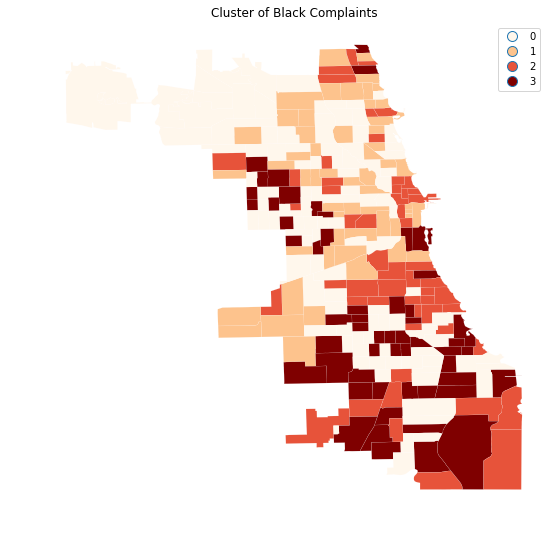

In [147]:
black5 = ps.Quantiles(total_beat.Black, k=5)
f, ax = plt.subplots(1, figsize=(9, 9))
beats_gpd.assign(cl=black5.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Cluster of Black Complaints")
plt.show()

/Users/patrickchang/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/patrickchang/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Users/patrickchang/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


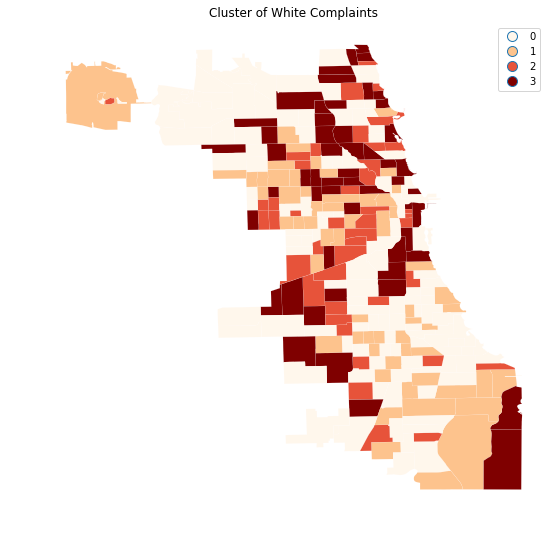

In [151]:
white5 = ps.Quantiles(total_beat.White, k=5)
f, ax = plt.subplots(1, figsize=(9, 9))
beats_gpd.assign(cl=white5.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Cluster of White Complaints")
plt.show()

/Users/patrickchang/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/patrickchang/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Users/patrickchang/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


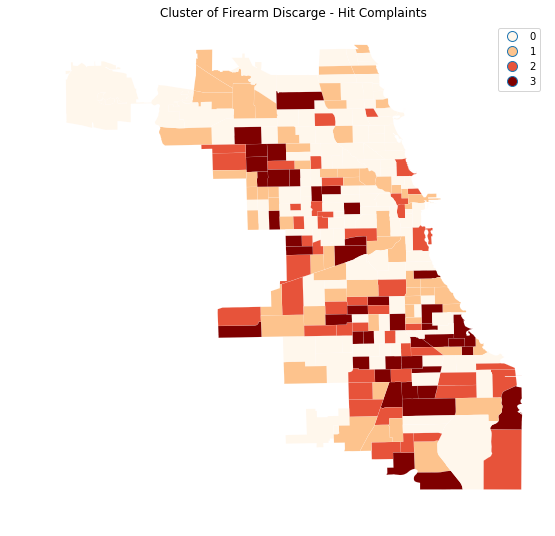

In [152]:
firearmhit5 = ps.Quantiles(total_beat.firearmhit, k=5)
f, ax = plt.subplots(1, figsize=(9, 9))
beats_gpd.assign(cl=firearmhit5.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Cluster of Firearm Discarge - Hit Complaints")
plt.show()

/Users/patrickchang/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/patrickchang/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Users/patrickchang/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


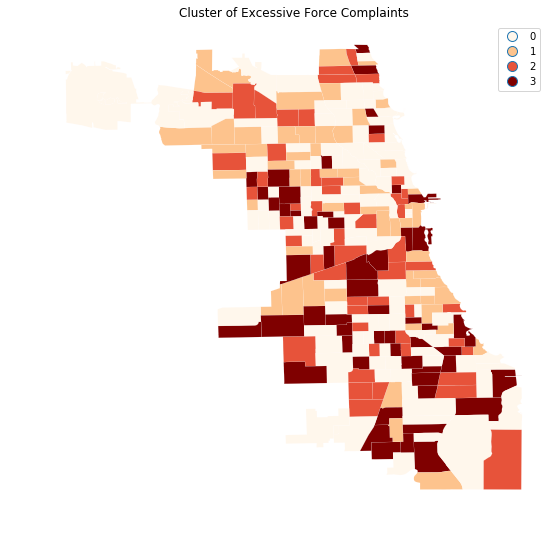

In [153]:
excess5 = ps.Quantiles(total_beat.excessforce, k=5)
f, ax = plt.subplots(1, figsize=(9, 9))
beats_gpd.assign(cl=excess5.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Cluster of Excessive Force Complaints")
plt.show()

In [148]:
total_beat.columns.values

array(['district', 'beat_num', 'sector', 'beat_x', 'geometry', 'beat_y',
       'bias', 'civilsuits', 'coercion', 'deathinjuryincustody',
       'domesticviolence', 'excessforce', 'firearmhit', 'firearmnohit',
       'firearmanimal', 'legalviol', 'misc', 'motordeath', 'ocdischarge',
       'operationviolation', 'searchseizure', 'taserdischarge',
       'tasernotif', 'denialcounsel', 'unnecessarydispweapon',
       'verbalabuse', 'beat', 'Black', 'AmerIndianAlaskan', 'Apia',
       'Hispanic', 'Unknown', 'White'], dtype=object)